# Deep Learning with Torch and Torch Autograd

(Much thanks to Soumith Chintala for providing intro material)

### Goal of this talk
* Understand torch and the neural networks package at a high-level.
* Train a small neural network on CPU and GPU
* Try out using autograd with your neural network

## What is Torch?

Torch is an scientific computing framework based on Lua[JIT] with strong CPU and CUDA backends.

Strong points of Torch:

* Efficient Tensor library (like NumPy) with an efficient CUDA backend
* Neural Networks package -- build arbitrary acyclic computation graphs with automatic differentiation
   * also with fast CUDA and CPU backends
* Good community and industry support - several hundred community-built and maintained packages.
* Easy to use Multi-GPU support and parallelizing neural networks

http://torch.ch  
https://github.com/torch/torch7/wiki/Cheatsheet

## What is Torch Autograd?

https://github.com/twitter/torch-autograd

Torch autograd is an automatic differentiation package, that will automatically calculate derivatives of any differentiable Torch function for you. For some function 
```
function f(params,...)
out = f(..)
``` 
with input `params` that is either a table of tensors, or a tensor, just call 
```
g = grad(f)
gradients, out = g(...)
```
to get a new function `g` that will return the output of `f`, along with the gradients of `f w.r.t. params`.

Where `NN` and related packages are mostly restricted to backpropagating through static compute graphs, autograd has no such limitation.

## Before getting started

* Based on Lua and runs on Lua-JIT (Just-in-time compiler) which is fast
* Lua is pretty close to javascript.
   * variables are global by default, unless `local` keyword is used
* Only has one data structure built-in, a table: `{}`. Doubles as a hash-table and an array.
* 1-based indexing.
* `foo:bar()` is the same as `foo.bar(foo)`

## Getting Started
#### Strings, numbers, tables - a tiny introduction

In [1]:
a = 'hello'

In [2]:
print(a)

hello	


In [3]:
b = {}

In [4]:
b[1] = a

In [5]:
print(b)

{
  1 : hello
}


In [6]:
b[2] = 30

In [7]:
for i=1,#b do -- the # operator is the length operator in Lua
    print(b[i]) 
end

hello	
30	


#### Tensors

In [8]:
a = torch.Tensor(5,3) -- construct a 5x3 matrix, uninitialized

In [9]:
a = torch.rand(5,3)
print(a)

 0.6277  0.2322  0.0828
 0.9762  0.5218  0.1150
 0.8547  0.4211  0.6836
 0.9151  0.7073  0.4151
 0.3680  0.3476  0.6907
[torch.DoubleTensor of size 5x3]



In [10]:
b=torch.rand(3,4)

In [11]:
-- matrix-matrix multiplication: syntax 1
a*b 

 0.6952  0.3667  0.2881  0.3769
 1.1848  0.7160  0.4963  0.6027
 1.3309  0.8330  0.9682  0.9374
 1.4295  1.0033  0.8370  0.8199
 0.9045  0.6785  0.8524  0.7135
[torch.DoubleTensor of size 5x4]



In [12]:
-- matrix-matrix multiplication: syntax 2
torch.mm(a,b) 

 0.6952  0.3667  0.2881  0.3769
 1.1848  0.7160  0.4963  0.6027
 1.3309  0.8330  0.9682  0.9374
 1.4295  1.0033  0.8370  0.8199
 0.9045  0.6785  0.8524  0.7135
[torch.DoubleTensor of size 5x4]



In [13]:
-- matrix-matrix multiplication: syntax 3
c=torch.Tensor(5,4)
c:mm(a,b) -- store the result of a*b in c

#### CUDA Tensors
Tensors can be moved onto GPU using the :cuda function

#### Exercise: Add two tensors

In [14]:
function addTensors(a,b)
    return a -- FIX ME
end

In [15]:
a = torch.ones(5,2)
b = torch.Tensor(3,4):fill(4)
print(addTensors(a,b))

 1  1
 1  1
 1  1
 1  1
 1  1
[torch.DoubleTensor of size 5x2]



### Neural Networks
Neural networks in Torch can be constructed using the `nn` package.

In [16]:
require 'nn';

`Modules` are the bricks used to build neural networks. Each are themselves neural networks, but can be combined with other networks using `containers` to create complex neural networks

For example, look at this network that classfies digit images:
![LeNet](http://fastml.com/images/cifar/lenet5.png)

It is a simple feed-forward network.   
It takes the input, feeds it through several layers one after the other, and then finally gives the output.

Such a network container is `nn.Sequential` which feeds the input through several layers.

In [17]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(1, 6, 5, 5)) -- 1 input image channel, 6 output channels, 5x5 convolution kernel
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.Linear(120, 84))
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems

print('Lenet5\n' .. net:__tostring());

Lenet5
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> output]
  (1): nn.SpatialConvolution(1 -> 6, 5x5)
  (2): nn.SpatialMaxPooling(2x2, 2,2)
  (3): nn.SpatialConvolution(6 -> 16, 5x5)
  (4): nn.SpatialMaxPooling(2x2, 2,2)
  (5): nn.View(400)
  (6): nn.Linear(400 -> 120)
  (7): nn.Linear(120 -> 84)
  (8): nn.Linear(84 -> 10)
  (9): nn.LogSoftMax
}	


Other examples of nn containers are shown in the figure below:
![containers](https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/nn_containers.png)

Every neural network module in torch has its forward computation defined, as well as its partial derivatives.
It has a `:forward(input)` function that computes the output for a given input, flowing the input through the network.
and it has a `:backward(input, gradient)` function that will differentiate each neuron in the network w.r.t. the gradient that is passed in. This is done via the chain rule. Calling `forward` and `backward` on the whole model (e.g. the `nn.Sequential()` container) will compose all of the functions together to calculate `forward`, and calling `backward` will calculate the gradients of loss with respect to the inputs through all of the modules, using the chain rule.

In [18]:
input = torch.rand(1,32,32) -- pass a random tensor as input to the network

In [19]:
output = net:forward(input)

In [24]:
print(output)

-2.1276
-2.2508
-2.3319
-2.2379
-2.4239
-2.4516
-2.2319
-2.3223
-2.3122
-2.3793
[torch.DoubleTensor of size 10]



In [25]:
net:zeroGradParameters() -- zero the internal gradient buffers of the network (will come to this later)

In [26]:
gradInput = net:backward(input, torch.rand(10))

In [27]:
print(#gradInput)

  1
 32
 32
[torch.LongStorage of size 3]



### Criterion: Defining a loss function
When you want a model to learn to do something, you give it feedback on how well it is doing. This function that computes an objective measure of the model's performance is called a __loss function__.

A typical loss function takes in the model's output and the groundtruth and computes a value that quantifies the model's performance.

The model then corrects itself to have a smaller loss.

In torch, loss functions are implemented just like neural network modules, and have automatic differentiation.  
They have two functions - `forward(input, target)`, `backward(input, target)`

For example:

In [28]:
criterion = nn.ClassNLLCriterion() -- a negative log-likelihood criterion for multi-class classification
criterion:forward(output, 3) -- let's say the groundtruth was class number: 3
gradients = criterion:backward(output, 3)

In [29]:
gradInput = net:backward(input, gradients)

##### Review of what you learnt so far
* Network can have many layers of computation
* Network takes an input and produces an output in the :forward pass
* Criterion computes the loss of the network, and it's gradients w.r.t. the output of the network.
* Network takes an (input, gradients) pair in it's backward pass and calculates the gradients w.r.t. each layer (and neuron) in the network.

##### Missing details
> A neural network layer can have learnable parameters or not.

A convolution layer learns it's convolution kernels to adapt to the input data and the problem being solved.  
A max-pooling layer has no learnable parameters. It only finds the max of local windows.

A layer in torch which has learnable weights, will typically have fields .weight (and optionally, .bias)

In [30]:
m = nn.SpatialConvolution(1,3,2,2) -- learn 3 2x2 kernels
print(m.weight) -- initially, the weights are randomly initialized

(1,1,.,.) = 
 -0.0940 -0.3883
 -0.3646 -0.2724

(2,1,.,.) = 
 -0.4547  0.2431
  0.4920 -0.0782

(3,1,.,.) = 
  0.0263 -0.2780
 -0.4802 -0.1994
[torch.DoubleTensor of size 3x1x2x2]



In [31]:
print(m.bias) -- The operation in a convolution layer is: output = convolution(input,weight) + bias

 0.3663
 0.3104
-0.0375
[torch.DoubleTensor of size 3]



There are also two other important fields in a learnable layer. The gradWeight and gradBias.
The gradWeight accumulates the gradients w.r.t. each weight in the layer, and the gradBias, w.r.t. each bias in the layer.

#### Training the network

For the network to adjust itself, it typically does this operation (if you do Stochastic Gradient Descent):
> weight = weight + learningRate * gradWeight [equation 1]

This update over time will adjust the network weights such that the output loss is decreasing.

Okay, now it is time to discuss one missing piece. Who visits each layer in your neural network and updates the weight according to Equation 1?

There are multiple answers, but we will use the answer that gives us the most flexibility.
We'll use `autograd` to join together the network and the loss function.

### What about data?
Generally, when you have to deal with image, text, audio or video data, you can use standard functions like: [__image.load__](https://github.com/torch/image#res-imageloadfilename-depth-tensortype) or [__audio.load__](https://github.com/soumith/lua---audio#usage) to load your data into a _torch.Tensor_ or a Lua table, as convenient.

Let us now use some simple data to train our network.

We shall use the CIFAR-10 dataset, which has the classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.  
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.
![CIFAR-10 image](https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png)

The dataset has 50,000 training images and 10,000 test images in total.

__We now have 5 steps left to do in training our first torch neural network__
1. Load and normalize data
2. Define Neural Network
3. Define Loss function
4. Train network on training data
5. Test network on test data.

__1. Load and normalize data__

Today, in the interest of time, we prepared the data before-hand into a 4D torch ByteTensor of size 10000x3x32x32 (training) and 10000x3x32x32 (testing)
Let us load the data and inspect it.

In [32]:
os.execute('wget -c https://s3.amazonaws.com/torch7/data/cifar10torchsmall.zip')
os.execute('unzip cifar10torchsmall.zip')
trainset = torch.load('cifar10-train.t7')
-- First, let's make sure our data is the right type
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.
testset = torch.load('cifar10-test.t7')
testset.data = testset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

Archive:  cifar10torchsmall.zip


In [33]:
print(trainset)

{
  label : ByteTensor - size: 10000
  data : DoubleTensor - size: 10000x3x32x32
}


In [34]:
print(#trainset.data)

 10000
     3
    32
    32
[torch.LongStorage of size 4]



For fun, let us display an image:

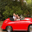

automobile	


In [35]:
itorch.image(trainset.data[100]) -- display the 100-th image in dataset
print(classes[trainset.label[100]])

### Make a function to grab a batch from our training set

In [36]:
batchSize = 8
function makeBatch(dataset,didx)
   didx = (didx-1) * batchSize + 1
   return {
      data = dataset.data[{ {didx,didx+batchSize-1} }],
      label = dataset.label[{ {didx,didx+batchSize-1} }],
   }
end

In [37]:
-- TODO:
-- View all the images in the batch





























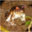

frog	


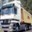

truck	


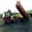

truck	


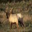

deer	


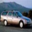

automobile	


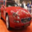

automobile	


bird	


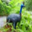

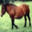

horse	


In [38]:
-- Solution
batch = makeBatch(trainset,1)
for i=1,batch.data:size(1) do
    itorch.image(batch.data[i])
    print(classes[batch.label[i]])
end

### Condition our data

__One of the most important things you can do in conditioning your data (in general in data-science or machine learning) is to make your data to have a mean of 0.0 and standard-deviation of 1.0.__

Let us do that as a final step of our data processing.

To do this, we introduce you to the tensor indexing operator.
It is shown by example:

In [39]:
redChannel = trainset.data[{ {}, {1}, {}, {}  }] -- this picks {all images, 1st channel, all vertical pixels, all horizontal pixels}

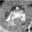

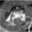

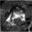

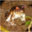

In [40]:
-- Each channel individually will be viewable as greyscale
for i=1,3 do
    itorch.image(trainset.data[{ {}, {i}, {}, {}  }][1]) -- a single channel will show as a black and white image
end
itorch.image(trainset.data[1])

In this indexing operator, you initally start with ___[{ }]___. You can pick all elements in a dimension using ___{}___ or pick a particular element using ___{i}___ where ___i___ is the element index. You can also pick a range of elements using ___{i1, i2}___, for example ___{3,5}___ gives us the 3,4,5 elements.

__Exercise: Select the 150th to 300th data elements of the data__

Moving back to mean-subtraction and standard-deviation based scaling, doing this operation is simple, using the indexing operator that we learnt above:

In [41]:
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future
for i=1,3 do -- over each image channel
    mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean() -- mean estimation
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std() -- std estimation
    print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
    trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

Channel 1, Mean: 125.83175029297	


Channel 1, Standard Deviation: 63.143400842609	


Channel 2, Mean: 123.26066621094	


Channel 2, Standard Deviation: 62.369209019002	


Channel 3, Mean: 114.03068681641	


Channel 3, Standard Deviation: 66.965808411114	


Try running the cell above twice... you'll see the mean shifts to close to 0,
and the standard deviation becomes close to 0

### Update our network to operate on RGB (3-channel) input

**Exercise:** Copy the neural network from the __Neural Networks__ section above and modify it to take 3-channel images (instead of 1-channel images as it was defined).  
Hint: You only have to change the first layer, change the number 1 to be 3.

Here's the solution, just need to alter the number of inputs channels.

In [42]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 6, 5, 5)) -- 3 input image channel, 6 output channels, 5x5 convolution kernel
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.Linear(120, 84))
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems

### Phrase our network as a predictor and a loss function

In [43]:
-- Wrap our neural network in a function we can use
-- to make a prediction, given a model

params, gradParams = net:getParameters()
function predict(model, input)
   model:forward(input)
   return model.output
end

In [44]:
-- Now, wrap our prediction function, along with
-- our criterion, so that we can get the gradients
-- of the loss with respect to the parameters

function df(model, criterion, input, target)
   -- First, zero out the gradient parameters
   gradParams:zero()
   -- Make a prediction
   prediction = predict(model, input)
   -- Now, check how good our prediction was, through our criterion
   loss = criterion:forward(prediction, target)
   -- Now, propagate the error as a gradient through the criterion
   -- and the model
   model:backward(input, criterion:backward(prediction, target))
   -- Return the loss, the gradient, and the original prediction
   return loss, gradParams, prediction
end

Let's define a loss function as well. Log-likelihood classification loss works well for a lot of classification problems.

In [45]:
criterion = nn.ClassNLLCriterion()

### Check that we can learn to predict the label of just a single image
A good debugging tip -- if your neural network can't overfit your data, something is wrong!

In [46]:
-- Make sure we've imported plotting code
Plot = require 'itorch.Plot'

In [47]:
-- Notice that before we train, the probabilities of a given class are all mostly uniform
classLogProbabilities = predict(net, trainset.data[1])
classProbabilities = classLogProbabilities:exp() -- we get out log probabilities, but we'd like regular ones
p = Plot()
    :line(torch.range(1,#classes),classProbabilities)
    :yaxis("Class probabilities (0-1)")
    :xaxis("Class ID")
    :title("Class probabilities of a single sample (untrained)")
    :draw()

Try running this cell below a few times, you'll see your net begin to overfit on the single training sample we've asked it to learn on. If it's not doing that, something weird is going on!  
  
When you're convinced yourself we're able to overfit, go back and reset the network by running the cells that a) define the network (cell starts with `net = `), defines the `predict` function and defines the `df` function. Then, skip the cell below, so you don't accidentally overfit to start.

In [50]:
-- SGD on one image + label
loss, gradParams, prediction = df(net, criterion, trainset.data[1], trainset.label[1])

-- Now update the parameters with some learning rate
params:add(-1e-2, gradParams)

-- And now make a plot to see what our class probabilities look like
classLogProbabilities = predict(net, trainset.data[1])
-- print(prediction,trainset.label[1])
classProbabilities = torch.exp(classLogProbabilities) -- we get out log probabilities, but we'd like regular ones
p = Plot()
    :line(torch.range(1,#classes),classProbabilities)
    :yaxis("Class probabilities (0-1)")
    :xaxis("Class ID")
    :title("Class probabilities of a single sample (untrained)")
    :draw()

### Alright, we're ready to loop over our data and really learn. First -- some reporting

We've convinced ourselves the network can learn something, at least it can overfit on a single sample.  
However, can it learn to make accurate predictions across a distribution of input data, and for more than just one input class?  
In order to track performance during training, we'll use a confusion matrix to visualize how often the network is making correct predictions, and what are the types of mistakes it is making.

In [51]:
-- The library 'optim' contains lots of useful utilities, but we'll just use this one guy
confusionMatrix = require('optim').ConfusionMatrix(classes)

### Our reporting is ready. Let's learn.

In [52]:
-- Loop over the data for a few epochs, with xlua reporting, confusion matrix accumulation.
nEpochs = 5
nTrainingExamples = trainset.data:size(1)
learningRate = 1e-3

for e=1,nEpochs do
   confusionMatrix:zero()
   print("Working on epoch "..tostring(e).."/"..tostring(nEpochs))

   -- Training loop
   for i=1,nTrainingExamples/batchSize do

      -- Get data
      data = makeBatch(trainset, i)

      -- Get gradient and prediction
      loss, gradients, prediction = df(net, criterion, data.data, data.label)

      -- Update parameters
      params:add(-learningRate, gradients)

      -- Update confusion matrix
      for i=1,prediction:size(1) do
         confusionMatrix:add(prediction[i], data.label[i])
      end

   end
   print(confusionMatrix)
end

Working on epoch 1/5	


ConfusionMatrix:
[[     521      22       1       2       2      24     168      13     145     107]   51.841% 	[class: airplane]
 [     113      46       0       3       3      14     404      16     173     202]   4.723% 	[class: automobile]
 [     291      23       1       1       5      20     476      36      71     108]   0.097% 	[class: bird]
 [     173      17       2       6       9      74     493      31      84     127]   0.591% 	[class: cat]
 [     138      21       1       0      11      39     581      20      73     115]   1.101% 	[class: deer]
 [     192      14       2       3       9      69     453      15     109      71]   7.364% 	[class: dog]
 [      86      25       1       1       3      37     691      31      49     106]   67.087% 	[class: frog]
 [     171      27       3       8      10      46     426      46     103     161]   4.595% 	[class: horse]
 [     417      17       0       1       1      42     170       9     238     130]   23.220% 	[class: ship]

ConfusionMatrix:
[[     434      78       3       9       5      37      51      44     208     136]   43.184% 	[class: airplane]
 [      55     275       0       7       9      42     165      37     141     243]   28.234% 	[class: automobile]
 [     202      83      20       6      27      66     363     116      36     113]   1.938% 	[class: bird]
 [      82      66      10      30      38     197     326      95      62     110]   2.953% 	[class: cat]
 [      68      53       4      14      56     106     461      92      32     113]   5.606% 	[class: deer]
 [      64      56      11      25      31     261     255      84      79      71]   27.855% 	[class: dog]
 [      32      62       4      13      21      79     605     101      15      98]   58.738% 	[class: frog]
 [      59      88       9      27      57     101     247     192      53     168]   19.181% 	[class: horse]
 [     220      92       1       5       3      81      36      22     350     215]   34.146% 	[class: sh

 8 : horse
      9 : ship
      10 : truck
    }
}
Working on epoch 3/5	


ConfusionMatrix:
[[     458      98       2      10       1      39      31      62     211      93]   45.572% 	[class: airplane]
 [      53     357       0      17       6      47     122      48     124     200]   36.653% 	[class: automobile]
 [     173     104      34      28      24      85     317     165      30      72]   3.295% 	[class: bird]
 [      53      97      22      73      25     231     260     138      35      82]   7.185% 	[class: cat]
 [      60      48      12      29      55     112     445     136      25      77]   5.506% 	[class: deer]
 [      28      75      26      67      21     330     188     112      41      49]   35.219% 	[class: dog]
 [      20      66      11      29      20      97     583     142       8      54]   56.602% 	[class: frog]
 [      41     103       7      32      32     114     191     320      32     129]   31.968% 	[class: horse]
 [     229     113       3       9       2      87      17      24     370     171]   36.098% 	[class: sh

ConfusionMatrix:
[[     464     100       4      14       4      31      24      71     207      86]   46.169% 	[class: airplane]
 [      55     425       1      22       7      40      75      53     100     196]   43.634% 	[class: automobile]
 [     149     104      92      37      62      86     265     153      28      56]   8.915% 	[class: bird]
 [      41     104      49     112      40     220     216     122      31      81]   11.024% 	[class: cat]
 [      62      57      32      39     124      99     362     139      26      59]   12.412% 	[class: deer]
 [      25      71      47      95      25     327     150     113      37      47]   34.899% 	[class: dog]
 [      18      61      25      47      40      93     570     120       5      51]   55.340% 	[class: frog]
 [      44      97      29      35      59     102     139     358      29     109]   35.764% 	[class: horse]
 [     210     119       6      12       2      71      15      24     399     167]   38.927% 	[class: 

  _target : FloatTensor - empty
  nclasses : 10
  classes : 
    {
      1 : airplane
      2 : automobile
      3 : bird
      4 : cat
      5 : deer
      6 : dog
      7 : frog
      8 : horse
      9 : ship
      10 : truck
    }
}
Working on epoch 5/5	


ConfusionMatrix:
[[     465      92      17      22      12      27      22      67     205      76]   46.269% 	[class: airplane]
 [      50     467       3      22       9      42      55      44      87     195]   47.947% 	[class: automobile]
 [     140      80     168      52     102      75     225     124      29      37]   16.279% 	[class: bird]
 [      37      87      71     165      47     213     180     105      32      79]   16.240% 	[class: cat]
 [      66      43      81      52     209      81     277     124      24      42]   20.921% 	[class: deer]
 [      24      51      82     119      38     334     124     100      27      38]   35.646% 	[class: dog]
 [      14      60      47      64      56      88     564      86       7      44]   54.757% 	[class: frog]
 [      37      76      51      44      92      90      93     397      31      90]   39.660% 	[class: horse]
 [     206     111      11      13       0      66      12      28     421     157]   41.073% 	[class:

In [53]:
print(confusionMatrix)

ConfusionMatrix:
[[     465      92      17      22      12      27      22      67     205      76]   46.269% 	[class: airplane]
 [      50     467       3      22       9      42      55      44      87     195]   47.947% 	[class: automobile]
 [     140      80     168      52     102      75     225     124      29      37]   16.279% 	[class: bird]
 [      37      87      71     165      47     213     180     105      32      79]   16.240% 	[class: cat]
 [      66      43      81      52     209      81     277     124      24      42]   20.921% 	[class: deer]
 [      24      51      82     119      38     334     124     100      27      38]   35.646% 	[class: dog]
 [      14      60      47      64      56      88     564      86       7      44]   54.757% 	[class: frog]
 [      37      76      51      44      92      90      93     397      31      90]   39.660% 	[class: horse]
 [     206     111      11      13       0      66      12      28     421     157]   41.073% 	[class:

      4 : cat
      5 : deer
      6 : dog
      7 : frog
      8 : horse
      9 : ship
      10 : truck
    }
}


### We're reducing training error. But how are we doing on a validation dataset?

__Test the network, print accuracy__

We have trained the network over the training dataset. It's doing ok, not great.  
But we need to check if the network has overfit, or can generalize to similar data.  
We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

We'll need to normalize the validation dataset, using the same statistics we computed for training dataset

In [54]:
testset.data = testset.data:double()   -- convert from Byte tensor to Double tensor
for i=1,3 do -- over each image channel
    testset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction    
    testset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

Okay, first step. Let us display an image from the test set to get familiar.

horse	


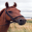

In [55]:
print(classes[testset.label[100]])
itorch.image(testset.data[100])

In [56]:
-- for fun, print the mean and standard-deviation of example-100
horse = testset.data[100]
print(horse:mean(), horse:std())

0.59066009532189	1.0665356205025	


Okay, now let us see what the neural network thinks these examples above are:

horse	


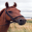

In [57]:
print(classes[testset.label[100]])
itorch.image(testset.data[100])
predicted = predict(net, testset.data[100])

In [58]:
-- the output of the network is Log-Probabilities. To convert them to probabilities, you have to take e^x 
predictedProb = torch.exp(predicted)
print(predictedProb)

 0.0639
 0.1371
 0.0797
 0.1163
 0.0583
 0.0640
 0.0539
 0.1285
 0.0381
 0.2603
[torch.DoubleTensor of size 10]



You can see the network predictions. The network assigned a probability to each classes, given the image.

To make it clearer, let us tag each probability with it's class-name:

In [62]:
for i=1,predicted:size(1) do
    print(classes[i], predictedProb[i])
end

airplane	0.06392711539247	
automobile	0.13705859940128	
bird	0.079686553651511	
cat	0.11630412198854	
deer	0.05825403621093	
dog	0.063960784190061	
frog	0.053941142065575	
horse	0.12847209715464	
ship	0.038094532697737	
truck	0.26030101724725	


That doesn't look so good. On my system, this predicts that the horse is a truck. A horsetruck. But how are we doing on the test set as a whole?

In [63]:
correct = 0
confusionMatrix:zero()
for i=1,testset.data:size(1) do
    local groundtruth = testset.label[i]
    local prediction = predict(net,testset.data[i])
    confusionMatrix:add(prediction, testset.label[i])
end

In [64]:
print(confusionMatrix)

ConfusionMatrix:
[[     473     102      37      23      15      23      27      57     189      54]   47.300% 	[class: airplane]
 [      41     562      16      48       8      27      52      30     101     115]   56.200% 	[class: automobile]
 [     112      66     262      78      82      50     210      87      24      29]   26.200% 	[class: bird]
 [      32      98     109     223      14     158     176     105      25      60]   22.300% 	[class: cat]
 [      50      61     142      67     156      45     317     119      24      19]   15.600% 	[class: deer]
 [      22      64     129     169      23     264     150     120      34      25]   26.400% 	[class: dog]
 [      10      67      71      84      39      40     589      44       2      54]   58.900% 	[class: frog]
 [      34      68      93      92      41      67      91     404      37      73]   40.400% 	[class: horse]
 [     199     152       8      23       6      39      11      26     416     120]   41.600% 	[class:

### Extras

__Try getting the network on the GPU__
  
I'll list the ingredients for getting a network onto the GPU below.

First, require 'cutorch' and 'cunn'

In [ ]:
require 'cutorch'
require 'cunn'

Then, you just have to cast your network to the GPU type

In [ ]:
net = net:cuda()

Also, transfer the criterion to GPU:

In [ ]:
criterion = criterion:cuda()

Ok, now the data:

In [ ]:
trainset.data = trainset.data:cuda()

Okay, let's train on GPU :) #sosimple

In [ ]:
-- Copy the training code from above

Why dont I notice MASSIVE speedup compared to CPU?  
Because your network is quite small.  
  
*Exercise:* Try increasing the size of your network (argument 1 and 2 of nn.SpatialConvolution(...), see what kind of speedup you get.

__Logging training error__  
  
You can try plotting your training error every epoch to visually monitor learning progress.  
The code below updates a graph every 100 milliseconds. You can try adapting it to your training loop to show
the training error.

In [ ]:
-- To get the average class accuracy from a ConfusionMatrix class, you can try
-- confusionMatrix:updateValids()
-- print(confusionMatrix.averageValid)

Plot = require 'itorch.Plot'

pts = {}
err = {}

p = nil
for i=1,30 do
    pts[#pts+1] = i
    err[#err+1] = 1.0/i
    if not p then
        p = Plot():line(pts,err):title('Training Error'):redraw()
    else
        p:line(pts,err):redraw()
    end
    sys.execute("sleep 0.1")
end

__Use autograd to train the network from above__  
  
  
Autograd lets you write arbitrary torch functions, and automatically get the derivative of those functions. Here's a small example:  

In [161]:
-- Some crazy torch function, with if statements (we could have while and for loops, too)
function f(a,b)
    c = a * b
    if b > 0 then
        d = torch.log(c)
    else
        d = torch.sin(c)
    end
    return d
end
print("Value: " .. f(2,3))

-- Calling grad() on a function returns a NEW function, that calculates the value as well as the gradient
-- of the original function (gradient w.r.t. first argument only, but the argument can be a table of tensors)
grad = require 'autograd'
g = grad(f)

gradient, value = g(2,3)
print("\nValue: "..value)
print("Gradient:"..gradient)

Value: 1.7917594692281	

Value: 1.7917594692281	
Gradient:0.5	


In autograd, you have to write your code in a procedural style, and be careful not to overwrite the internals of any variables.
So, instead of doing

```lua
a = torch.randn(3,3)
a:exp() -- now the content of a has been exponentiated. doesn't work in autograd, though!
```

do

```lua
a = torch.randn(3,3)
a = torch.exp(a)
```

however, this is generally a bad idea in autograd
```lua
a = torch.randn(3,3)
-- can't overwrite indices! because when doing backprop, 
-- we've lost the original content of a[i]
a[1] = torch.exp(a[1]) 
```

So using torch functions like `torch.exp`, `torch.mm`, `torch.log` and ops like `+,/,-,*` are no problem in autograd. But there's been an enormous amount of work put into building really efficient `NN` modules. Fortunately, we can use those in autograd as well, but we have to first convert them from objects (which are strung together using containers, as we saw above), into functions. Here's how:

In [162]:
predict_cnn, params_cnn = grad.functionalize(net)

What just happened? We created a function which takes in the neural net parameters,  
as well as input data, and calls the underlying `nn.Sequential` model and returns the results. Under the hood, we'll also handle backpropagation if this function is used, and we need gradients through it.

In [163]:
predict_cnn(params_cnn, trainset.data[1])

-6.5287
-3.9768
-2.8086
-1.8664
-2.2169
-2.2016
-0.7777
-2.6404
-5.9565
-4.4337
[torch.DoubleTensor of size 10]



So, we can construct the trainable model that we had above as so:

In [203]:
fCriterion = grad.functionalize(criterion) -- we can functionalize criterions, but they don't have parameters

function f(params, input, target)
   prediction = predict_cnn(params, input)
   loss = fCriterion(prediction, target)
   return loss, prediction
end

-- Autograd will give you a function that calculates gradients
df = grad(f)

In [204]:
gradParams, loss, prediction = df(params_cnn, trainset.data[1], trainset.label[1])

-- Now update the parameters with some learning rate
for i=1,#params_cnn do -- loop over each parameter (they're no longer one big tensor)
    params_cnn[i]:add(1e-2,gradParams[i]) -- but gradParams is the same size
end

-- And now make a plot to see what our class probabilities look like
classLogProbabilities = predict_cnn(params_cnn, trainset.data[1])
classProbabilities = torch.exp(classLogProbabilities) -- we get out log probabilities, but we'd like regular ones
p = Plot()
    :line(torch.range(1,#classes),classProbabilities)
    :yaxis("Class probabilities (0-1)")
    :xaxis("Class ID")
    :title("Class probabilities of a single sample (untrained)")
    :draw();

One thing that's trivial in autograd is to add more arithmetic to the model,
without having to worry about updating the update step (because that's taken care of for you
by using automatic differentiation)

In [205]:
lambda = 1e-2
function f(params, input, target)
   prediction = predict_cnn(params, input)
   loss = fCriterion(prediction, target)
               + lambda*torch.sum(torch.pow(params[1],2)) -- add in some regularization
               + lambda*torch.sum(torch.pow(params[3],2))
               + lambda*torch.sum(torch.pow(params[5],2))

   return loss, prediction
end

-- Autograd will give you a function that calculates gradients
df = grad(f)

__Exercise__: Try training with regularization, or make other fun modifications!  

Note that it's not too crazy to chain together multiple networks using autograd. Use it as "neural network glue"! For instance, for video classification, try merging a CNN with an LSTM.

**Goals achieved:**
* Understand torch and the neural networks package at a high-level.
* Train a small neural network on CPU and GPU
* Use autograd to take gradients of more complicated functions

**What else should I try next?**:

* Dig in more to autograd (and join the Slack channel): https://github.com/twitter/torch-autograd
* Train on imagenet with multiple GPUs: https://github.com/soumith/imagenet-multiGPU.torch
* Train recurrent networks with LSTM on text: https://github.com/wojzaremba/lstm
* More demos and tutorials: https://github.com/torch/torch7/wiki/Cheatsheet
* Chat with developers of Torch: http://gitter.im/torch/torch7
* Ask for help: http://groups.google.com/forum/#!forum/torch7